# Denoising with SURE 


# SetUp

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%load_ext autoreload
%autoreload 2

In [2]:
# Based on denoising.ipynb from https://github.com/DmitryUlyanov/deep-image-prior
# Clone deep image prior https://github.com/DmitryUlyanov/deep-image-prior within this directory to download dependencies

# # Import libs
from __future__ import print_function

from models import skip

import time

import torch.optim

from utils.denoising_utils import *

import copy
import gc 
from matplotlib import pyplot as plt

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

# torch.backends.cudnn.enabled = False
# torch.backends.cudnn.benchmark = False
# dtype = torch.float32

imsize=512
PLOT =  True
sigma = 25
sigma_ = sigma / 255.

## Getting Image

Please input the path to your image. 

In [3]:
## denoising
# fname = '/home/gnahum/forensiccar2small.jpg'
fname = 'F16_GT.png'
fname = 'data/denoising/'+fname

## Setting up Plot/NN

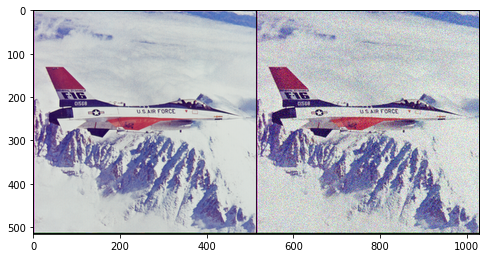

Number of params: 930096


In [4]:
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)
img_noisy_np = img_np
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 6);


INPUT = 'noise'  # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net'  # 'net,input'

TrainwSURE=True
if TrainwSURE:
    reg_noise_std = 0
else:
    reg_noise_std =  1. / 30. #Need to jitter input when training only wrt data fidelity term
LR = .001

OPTIMIZER = 'adam'  # 'LBFGS'
show_every = 100


num_iter = 400 ### CHANGE IF YOU WANT. 

input_depth = img_np.shape[0]
output_depth = img_np.shape[0]
figsize = 5
channels = 64
net = skip(input_depth, output_depth, num_channels_down=[channels, channels, channels, channels, channels, channels, channels, channels],
           num_channels_up=[channels, channels, channels, channels, channels, channels, channels, channels],
           num_channels_skip=[15, 13, 11, 9, 7, 5, 3, 1],
           upsample_mode=['nearest', 'nearest', 'nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear', 'bilinear'],
           need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

net = net.type(dtype)



net_input = torch.reshape(torch.from_numpy(img_noisy_np).type(dtype).detach(),
                          (1, input_depth, img_pil.size[1], img_pil.size[0]))

# Compute number of parameters
s = sum([np.prod(list(p.size())) for p in net.parameters()]);
print('Number of params: %d' % s)


## Optimization Setup

In [5]:
# Loss
mse_el = torch.nn.MSELoss(reduction='none')
mse_norm = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_torch(img_noisy_np).type(dtype)
img_clean_var = np_to_torch(img_np).type(dtype)
net_input_saved = net_input.data.clone()
input_noise_vec = net_input.data.clone()

# SURE

In [6]:
def sure(out):

    epsilon = 1e-3  # * torch.max(net_input)
    eta = input_noise_vec.normal_()
    net_input_perturbed = net_input.data.clone() + (eta * epsilon)
    out_perturbed = net(net_input_perturbed)
    dx=out_perturbed - out

    fidelity_loss = mse_norm(out, img_noisy_var)
    # Calculate the MC divergence and SURE loss before network changes (loss.backward())
    eta_dx = torch.sum(eta * dx)  # Inner product between eta and (x_perturbed-x). They must have the same dimensions
    MCdiv = eta_dx / epsilon
    div_term = 2. * sigma_ ** 2 * MCdiv / n
    return (fidelity_loss - sigma_ ** 2 + div_term, div_term)


def sure_error_map(out, mcdiv=1): 
    # remake tensors to not require gradient (save's GPU memory)
    out = torch.tensor(out, requires_grad=False)
    net_input_no_grad = torch.tensor(net_input, requires_grad=False)
    x = torch.tensor(net_input, requires_grad=False)
    
    #Begin SURE-Error-Map Formula
    error_map_loss = (out - img_noisy_var).pow(2)
    
    eta = net_input_no_grad.normal_()
    epsilon = 1e-3
    eps = epsilon + eta
    x_eps = x + eps 
    derivative = torch.tensor((net(x_eps) - out)/eps, requires_grad=False)
    
    # can parallize as each iteration is independent. 
    for i in range(1, mcdiv): 
        eta = net_input_no_grad.normal_()
        eps = epsilon * eta
        x_eps = x + eps 
        deriva = (net(x_eps) - out)/eps # returns a new tensor with required_grad=True
        deriva = torch.tensor(deriva, requires_grad=False) # erases the gradient to free GPU. 
        derivative += deriva
        
    derivative = derivative/mcdiv #the mean of all the derivatives. 
    div_term = 2. * sigma_ **2 * derivative 
    return error_map_loss - sigma_**2 + div_term, div_term
    

### Function in each iteration of NN

In [15]:
n = img_np.size

global MSE_losses_wrtinput
global MSE_losses_wrttruth
global SURE_losses
global Divergences_terms
MSE_losses_wrtnoisy = np.zeros(num_iter)
MSE_losses_wrttruth = np.zeros(num_iter)
SURE_losses = np.zeros(num_iter)
Divergences_terms = np.zeros(num_iter)

i = 0

global min_loss
min_loss=np.inf

def closure():
    global i

    if reg_noise_std > 0:
        net_input.data = net_input_saved + (input_noise_vec.normal_() * reg_noise_std)

    out_0 = net(net_input_saved)
    out = net(net_input)
    out_2 = net(net_input)
    
    global MSE_losses_wrtnoisy
    global MSE_losses_wrttruth

    global SURE_losses
    global Divergences_terms

    fidelity_loss = mse_norm(out, img_noisy_var)
    true_loss = mse_norm(out, img_clean_var)
    MSE_losses_wrtnoisy[i] = fidelity_loss
    MSE_losses_wrttruth[i] = true_loss

    SURE_loss, div_term = sure_error_map(out, 100)
    SURE_losses = SURE_loss
    Divergences_terms = div_term
    global min_loss
    global best_net
    if SURE_loss < min_loss:
        min_loss=SURE_loss
        best_net=copy.deepcopy(net)
            
    print('Iteration %05d' % i, '\r',end='')
    if PLOT and i % show_every == 0:
        out_0_np = torch_to_np(out_0)
        plot_image_grid([np.clip(out_0_np, 0, 1)], factor=figsize, nrow=1)
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        out_2_np = torch_to_np(out_2)
        plot_image_grid([np.clip(out_2_np, 0, 1)], factor=figsize, nrow=1)

    i += 1
    if TrainwSURE:
        SURE_loss.backward(SURE_loss)
        return SURE_loss
    else:
        fidelity_loss.backward()
        return fidelity_loss

# Optimize!

In [16]:
start_time = time.time()
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)
end_time=time.time() - start_time
out = net(net_input)
out_np = torch_to_np(out)
q = plot_image_grid([np.clip(out_np, 0, 1),img_noisy_np, img_np], factor=13);
true_error_map_np = (out_np - img_np)**2


Starting optimization with ADAM


/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/gnahum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/gnahum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To 

{}


AttributeError: 'float' object has no attribute 'mean'

***Generate Error Map***

In [ ]:
error_map_tensor = sure_error_map(out, mcdiv=100) 
error_map_np = torch_to_np(error_map_tensor) 

/home/gnahum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/gnahum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/gnahum/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/gnahum/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn

**plot sure error map v. true error map**

We clip the ```error_map``` because the minimum value may be negative and we want it to be 0. We then exponentiate it for visual purposes

In [ ]:
q = plot_image_grid([np.clip(error_map_np, 0, 1)**0.12, true_error_map_np**0.2],
                    factor=13, name="Colored Error Map: (mcdiv=100) (.2 factor)")